In [1]:
#!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd

# 1. Hangi hisseyi istiyoruz? (Ticker Sembolü)
hisse_kodu = "NVDA"

# 2. Hangi tarih aralığı?
baslangic_tarihi = "2022-01-01"
bitis_tarihi = "2026-01-01"

# 3. Veriyi indiriyoruz (download)
# Bu fonksiyon bize bir 'DataFrame' (Tablo) döndürecek.
df = yf.download(hisse_kodu, start=baslangic_tarihi, end=bitis_tarihi)

# Sütun isimlerindeki karmaşayı (MultiIndex) düzeltelim
# Sadece ilk katmanı (Price, Open vs.) al, altındaki (NVDA) yazısını at diyoruz.
df.columns = df.columns.droplevel(1)

/tmp/ipython-input-288021577.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(hisse_kodu, start=baslangic_tarihi, end=bitis_tarihi)
[*********************100%***********************]  1 of 1 completed



VERİ SETİNİN SON HALİ (İLK 5 SATIR)

Price           Close       High        Low       Open     Volume
Date                                                             
2022-01-03  30.062769  30.651628  29.727418  29.757361  391547000
2022-01-04  29.233370  30.409092  28.294189  30.218461  527154000
2022-01-05  27.550627  29.359123  27.479765  28.893025  498064000
2022-01-06  28.123518  28.383016  27.012671  27.586558  454186000
2022-01-07  27.194319  28.367048  27.004686  28.086591  409939000


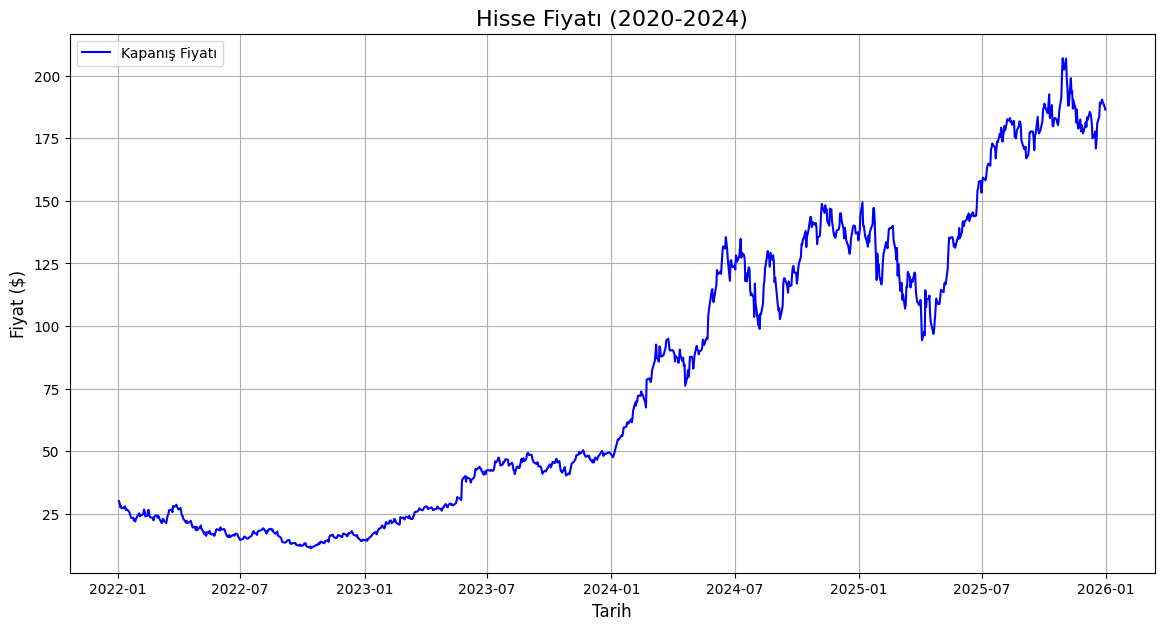

In [3]:
import matplotlib.pyplot as plt

# Eğer sütunlar hala karmaşıksa düzelt, değilse dokunma diyen bir kontrol:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

print("\n" + "="*50)
print("VERİ SETİNİN SON HALİ (İLK 5 SATIR)")
print("="*50 + "\n")
print(df.head())

# Şimdi Grafik Çizelim (Plotting)
plt.figure(figsize=(14, 7)) # Çerçevenin boyutunu ayarla (Genişlik, Yükseklik)

# 'Close' (Kapanış) fiyatını çizdiriyoruz
# Matematiksel olarak: x ekseni = Zaman (Index), y ekseni = Fiyat
plt.plot(df.index, df['Close'], label='Kapanış Fiyatı', color='blue')

plt.title('Hisse Fiyatı (2022-2026)', fontsize=16)
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Fiyat ($)', fontsize=12)
plt.legend() # Sol üstteki kutucuk (Hangi çizgi neyi gösteriyor)
plt.grid(True) # Izgara ekle ki değerleri okumak kolay olsun
plt.show() # Grafiği ekrana bas

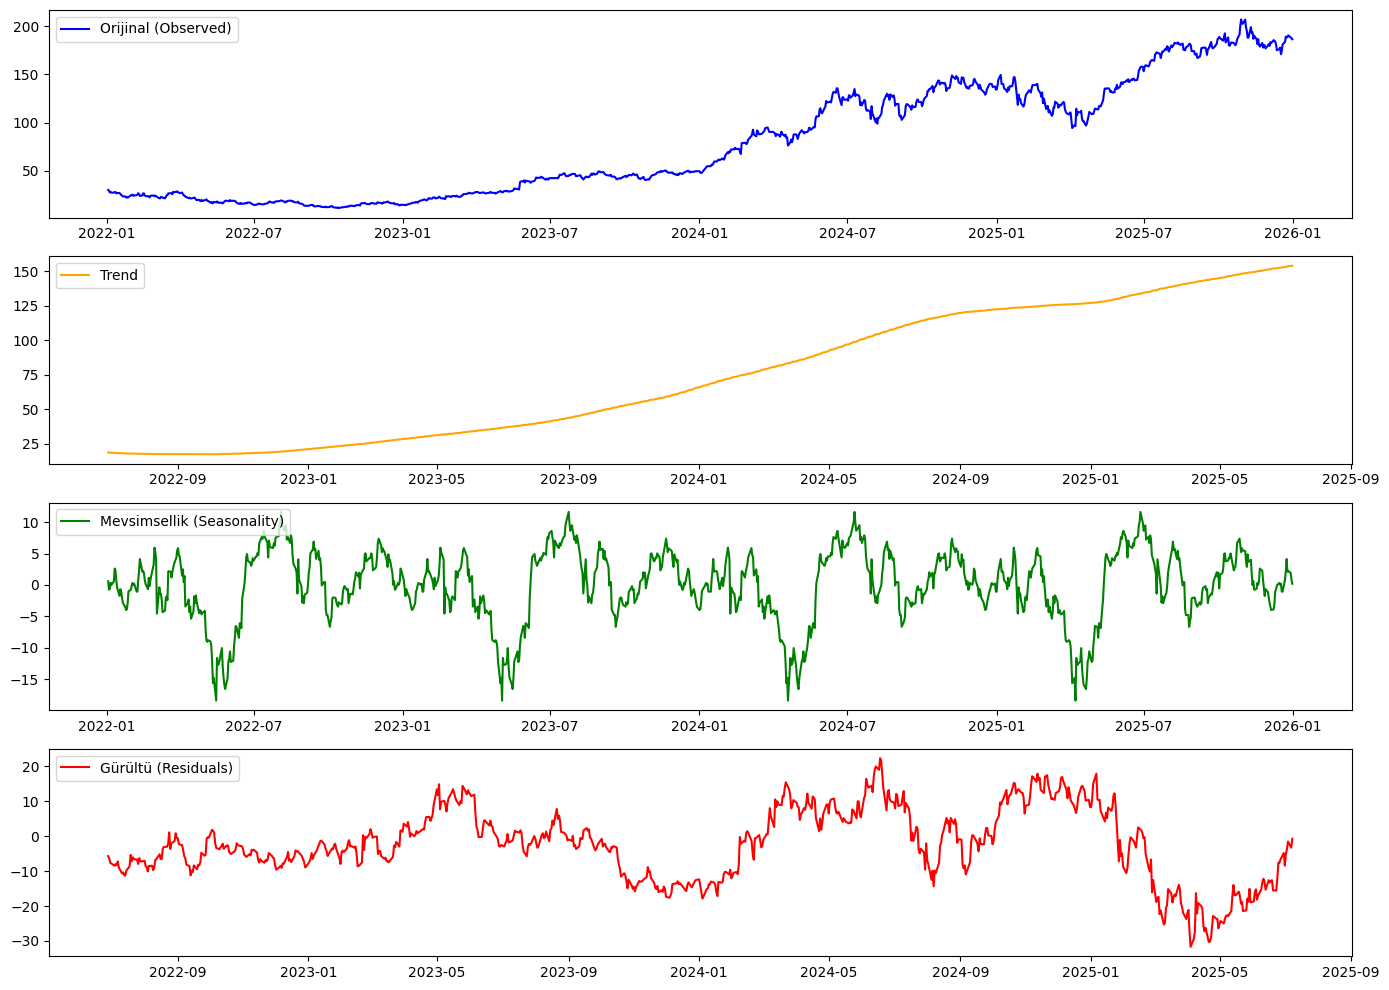

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Veri Hazırlığı: Hafta sonları boş olduğu için bazen sorun çıkarır.
# Bu yüzden 'Close' sütununu alıp eksikleri dolduruyoruz (Forward Fill)
ts_data = df['Close'].asfreq('B').ffill()

# 2. Ayrıştırma İşlemi (Decomposition)
# model='additive': Toplamsal model (Fiyat = Trend + Mevsim + Gürültü)
# period=252: Bir yılda yaklaşık 252 iş günü (borsa günü) vardır. Yıllık döngüye bakıyoruz.
result = seasonal_decompose(ts_data, model='additive', period=252)

# 3. Sonuçları Çizelim
plt.figure(figsize=(14, 10))

# Orijinal Veri
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Orijinal (Observed)', color='blue')
plt.legend(loc='upper left')

# Trend (Eğilim)
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

# Seasonality (Mevsimsellik)
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Mevsimsellik (Seasonality)', color='green')
plt.legend(loc='upper left')

# Residuals (Gürültü/Artık)
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Gürültü (Residuals)', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("ADF Testi Sonuçları:")
    # adfuller fonksiyonu bize 5-6 tane değer döndürür, biz ilk ikisine odaklanacağız
    dftest = adfuller(timeseries, autolag='AIC')

    # Çıktıyı güzelce etiketleyelim
    dfoutput = pd.Series(dftest[0:4], index=['Test İstatistiği','p-value','# Lags Used','# Observations'])

    print(dfoutput)
    print("-" * 30)

    # Yorumlama kısmı (Otomatik Yapsın)
    if dfoutput['p-value'] < 0.05:
        print("SONUÇ: Seri DURAĞANDIR (Stationary).")
        print("H0 reddedildi. İstatistiksel özellikler zamanla değişmiyor.")
    else:
        print("SONUÇ: Seri DURAĞAN DEĞİLDİR (Non-Stationary).")
        print("H0 reddedilemedi. Seri zamanla değişen bir trende veya varyansa sahip.")

# Testi Uygulayalım
# 1. Ham Fiyat Verisi (Close)
print("--- 1. HAM FİYAT VERİSİ ---")
adf_test(df['Close'])

--- 1. HAM FİYAT VERİSİ ---
ADF Testi Sonuçları:
Test İstatistiği      0.302683
p-value               0.977467
# Lags Used           4.000000
# Observations      998.000000
dtype: float64
------------------------------
SONUÇ: Seri DURAĞAN DEĞİLDİR (Non-Stationary).
H0 reddedilemedi. Seri zamanla değişen bir trende veya varyansa sahip.


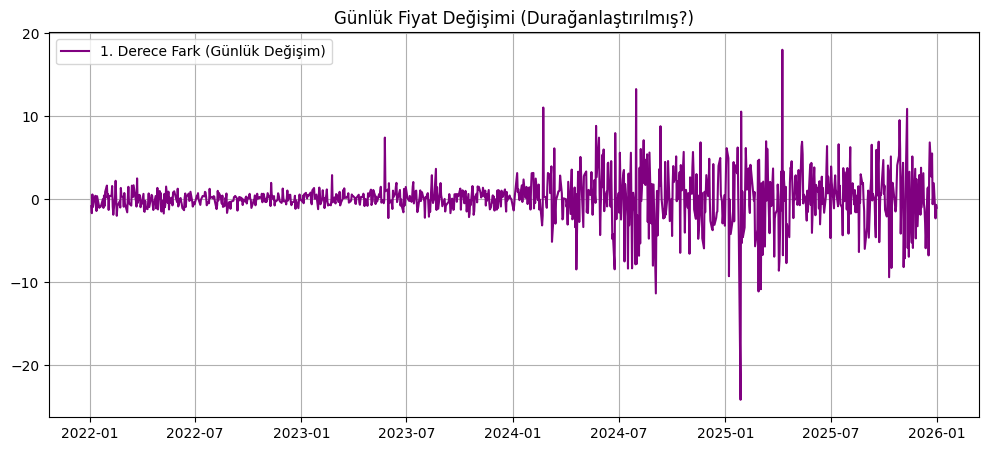

--- 1. TÜREV (FARK) ALINMIŞ VERİ ---
ADF Testi Sonuçları:
Test İstatistiği   -1.731126e+01
p-value             5.552568e-30
# Lags Used         3.000000e+00
# Observations      9.980000e+02
dtype: float64
------------------------------
SONUÇ: Seri DURAĞANDIR (Stationary).
H0 reddedildi. İstatistiksel özellikler zamanla değişmiyor.


In [6]:
# 1. Fark Alma (Differencing) - Birinci Türev
# .diff() fonksiyonu: Bugünden dünü çıkarır.
df_diff = df['Close'].diff().dropna()
# .dropna(): İlk günün "dünü" olmadığı için NaN (boş) olur, onu atıyoruz.

# 2. Farkı Alınmış Veriyi Çizelim (Gözümüzle görelim)
plt.figure(figsize=(12, 5))
plt.plot(df_diff, label='1. Derece Fark (Günlük Değişim)', color='purple')
plt.title("Günlük Fiyat Değişimi (Durağanlaştırılmış?)")
plt.legend()
plt.grid()
plt.show()

# 3. Tekrar Test Edelim (Bakalım p-value düştü mü?)
print("--- 1. TÜREV (FARK) ALINMIŞ VERİ ---")
adf_test(df_diff)

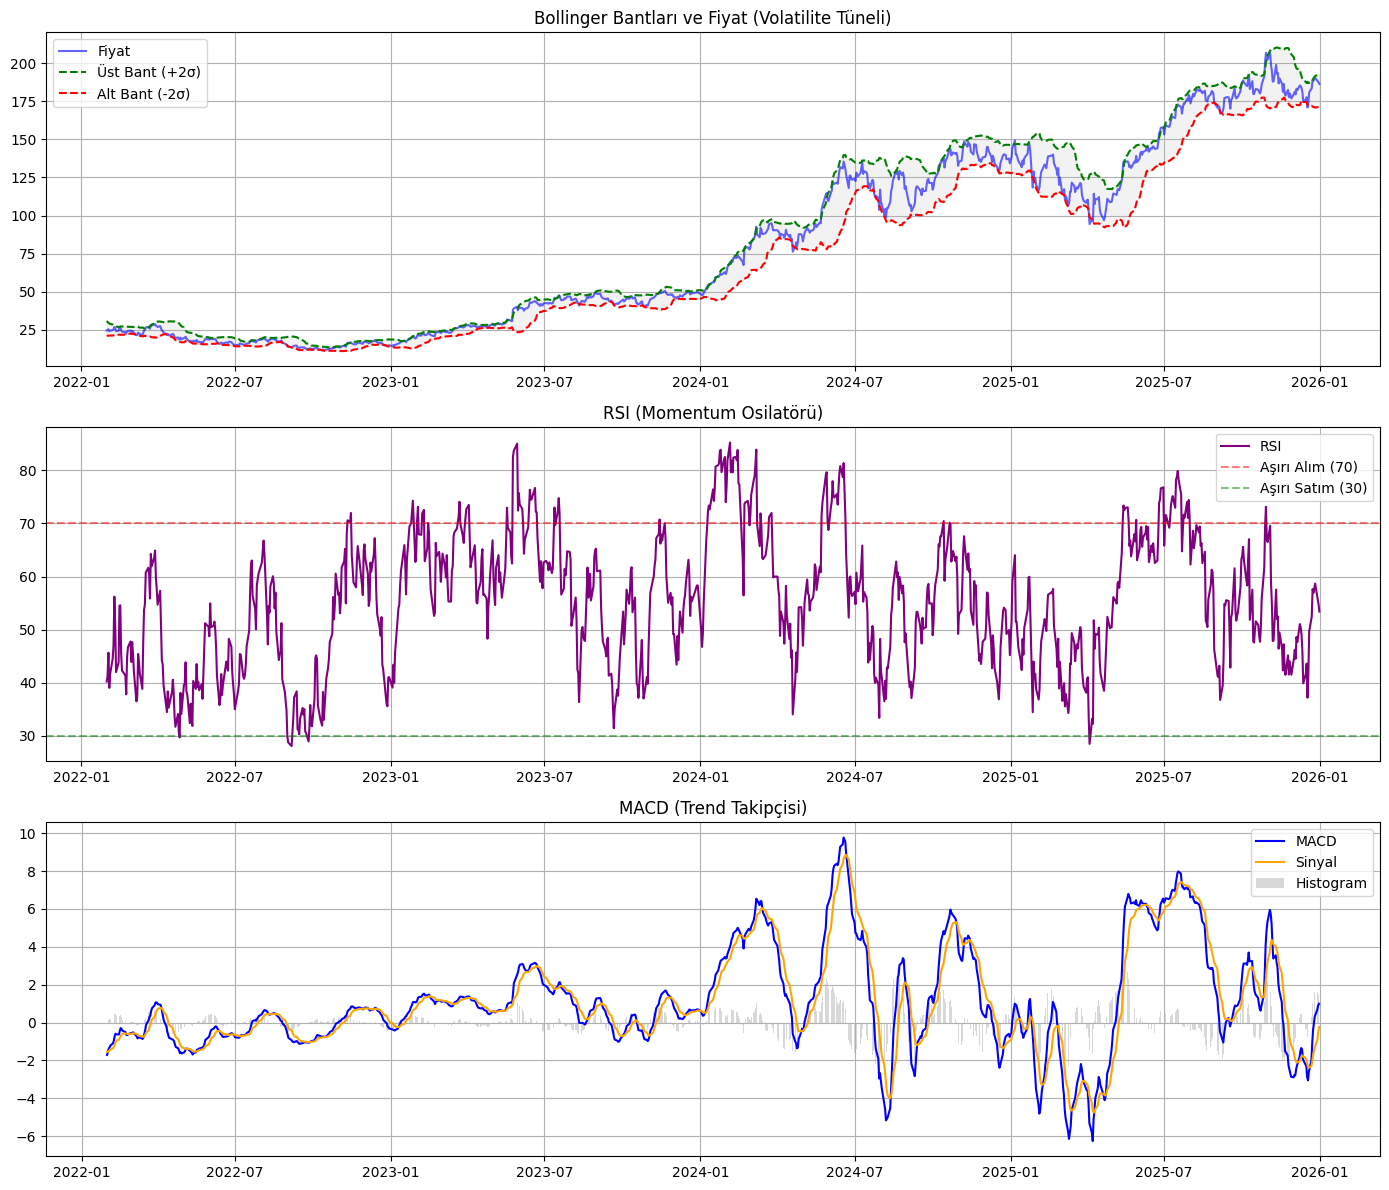

In [7]:
import numpy as np

# --- 1. FONKSİYONLAR (Formülleri Elle Yazıyoruz) ---

def calculate_rsi(data, window=14):
    """
    RSI (Relative Strength Index) Matematiksel Hesabı:
    1. Pozitif ve Negatif farkları ayır.
    2. 'Window' günlük ortalamalarını al.
    3. RS = (Ortalama Kazanç / Ortalama Kayıp)
    4. RSI = 100 - (100 / (1 + RS))
    """
    diff = data.diff(1)

    # Kazanç (Gain) ve Kayıp (Loss) serilerini oluştur
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)

    # Üstel Hareketli Ortalama (EMA) kullanıyoruz (Wilder'ın yöntemi)
    avg_gain = gain.ewm(alpha=1/window, min_periods=window).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, slow=26, fast=12, signal=9):
    """
    MACD (Moving Average Convergence Divergence):
    1. Hızlı EMA (12) - Yavaş EMA (26) = MACD Hattı
    2. MACD Hattının 9 günlük EMA'sı = Sinyal Hattı
    """
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_bollinger(data, window=20):
    """
    Bollinger Bantları:
    1. Orta Bant = 20 Günlük Basit Hareketli Ortalama (SMA)
    2. Standart Sapma (Sigma) hesapla.
    3. Üst Bant = Orta + 2*Sigma
    4. Alt Bant = Orta - 2*Sigma
    """
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# --- 2. HESAPLAMA ---

# Fonksiyonları verimize uygulayalım
df['RSI'] = calculate_rsi(df['Close'])
df['MACD'], df['MACD_Signal'] = calculate_macd(df['Close'])
df['BB_Middle'], df['BB_Upper'], df['BB_Lower'] = calculate_bollinger(df['Close'])

# NaN verileri temizle (Hesaplama başlangıcındaki boşluklar)
df_indicators = df.dropna()

# --- 3. GÖRSELLEŞTİRME ---

plt.figure(figsize=(14, 12))

# Grafik 1: Fiyat ve Bollinger Bantları
plt.subplot(3, 1, 1)
plt.plot(df_indicators.index, df_indicators['Close'], label='Fiyat', color='blue', alpha=0.6)
plt.plot(df_indicators.index, df_indicators['BB_Upper'], label='Üst Bant (+2σ)', color='green', linestyle='--')
plt.plot(df_indicators.index, df_indicators['BB_Lower'], label='Alt Bant (-2σ)', color='red', linestyle='--')
plt.fill_between(df_indicators.index, df_indicators['BB_Upper'], df_indicators['BB_Lower'], color='gray', alpha=0.1)
plt.title('Bollinger Bantları ve Fiyat (Volatilite Tüneli)')
plt.legend()
plt.grid(True)

# Grafik 2: RSI
plt.subplot(3, 1, 2)
plt.plot(df_indicators.index, df_indicators['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', alpha=0.5, label='Aşırı Alım (70)')
plt.axhline(30, color='green', linestyle='--', alpha=0.5, label='Aşırı Satım (30)')
plt.title('RSI (Momentum Osilatörü)')
plt.legend()
plt.grid(True)

# Grafik 3: MACD
plt.subplot(3, 1, 3)
plt.plot(df_indicators.index, df_indicators['MACD'], label='MACD', color='blue')
plt.plot(df_indicators.index, df_indicators['MACD_Signal'], label='Sinyal', color='orange')
plt.bar(df_indicators.index, df_indicators['MACD'] - df_indicators['MACD_Signal'], label='Histogram', color='gray', alpha=0.3)
plt.title('MACD (Trend Takipçisi)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **BÖLÜM 2: HABER VERİSİ VE NLP**

In [8]:
from datetime import datetime

def get_stock_news(ticker_symbol):
    """
    Belirtilen hisse için Yahoo Finance üzerinden güncel haberleri çeker,
    yeni JSON yapısına göre ayrıştırır ve temiz bir DataFrame döndürür.
    """
    print(f"📡 {ticker_symbol} için haber ağına bağlanılıyor...")

    # 1. Veriyi Çek
    try:
        stock = yf.Ticker(ticker_symbol)
        news_list = stock.news
    except Exception as e:
        print(f"Hata: Veri çekilemedi. {e}")
        return pd.DataFrame()

    # 2. Ayrıştır (Parsing)
    parsed_data = []

    for item in news_list:
        # Yeni yapıda veriler 'content' anahtarının içinde
        content = item.get('content', {})
        provider = content.get('provider', {})

        # Eksik veri durumunda hata vermemesi için .get() kullanıyoruz
        news_item = {
            'Tarih': content.get('pubDate'),
            'Başlık': content.get('title'),
            'Özet': content.get('summary'),
            'Link': content.get('canonicalUrl', {}).get('url'), # Bazen link yapısı da değişebilir
            'Yayıncı': provider.get('displayName')
        }
        parsed_data.append(news_item)

    # 3. Tabloya Dönüştür
    df_news = pd.DataFrame(parsed_data)

    # Tarih formatını okunabilir hale getirelim (Opsiyonel ama şık durur)
    # Gelen format genellikle ISO 8601'dir, pandas bunu otomatik tanır.
    if not df_news.empty:
        df_news['Tarih'] = pd.to_datetime(df_news['Tarih'])

    print(f"✅ Toplam {len(df_news)} adet haber başarıyla işlendi.\n")
    return df_news

# --- KULLANIM ---

# Fonksiyonu çağır ve sonucu bir değişkene ata
df_haberler = get_stock_news(hisse_kodu)

# Sonucu göster
# (Pandas dataframe'i olduğu için colab'de güzel tablo olarak çıkar)
df_haberler.head(10)

📡 NVDA için haber ağına bağlanılıyor...
✅ Toplam 10 adet haber başarıyla işlendi.



,Tarih,Başlık,Özet,Link,Yayıncı
0,2026-02-02 00:24:13+00:00,"Stock market today: Dow, S&P 500, Nasdaq whips...",Wall Street is on edge after Friday's sharp re...,https://finance.yahoo.com/news/live/stock-mark...,Yahoo Finance
1,2026-02-01 19:00:00+00:00,Could there be risks to allowing AI chip sales...,"Christopher Miller, professor at Tufts Univers...",https://finance.yahoo.com/video/could-there-be...,Yahoo Finance Video
2,2026-02-02 15:02:00+00:00,Oracle Plans to Raise Up to $50 Billion for AI...,The cloud-services giant said it expects to ra...,https://www.wsj.com/tech/oracle-shares-fall-pr...,The Wall Street Journal
3,2026-02-02 14:50:32+00:00,3 reasons why BofA expects compute stocks to ’...,Investing.com -- Bank of America expects compu...,https://finance.yahoo.com/news/3-reasons-why-b...,Investing.com
4,2026-02-02 14:43:54+00:00,"European stocks rise as oil tumbles, while tec...",Oil prices fell and gold steadied as concerns ...,https://finance.yahoo.com/news/oil-tumbles-ira...,AFP
5,2026-02-02 14:36:21+00:00,Oracle to Raise Up to $50 Billion in Debt and ...,The company is raising money to build addition...,https://finance.yahoo.com/news/oracle-raise-50...,Bloomberg
6,2026-02-02 14:14:34+00:00,Sector Update: Tech Stocks Decline Premarket M...,Technology stocks were declining premarket Mon...,https://finance.yahoo.com/news/sector-tech-sto...,MT Newswires
7,2026-02-02 14:13:22+00:00,Oracle’s US$50b AI Cloud Raise Versus Valuatio...,Oracle plans to raise $45b to $50b through a m...,https://finance.yahoo.com/news/oracle-us-50b-a...,Simply Wall St.
8,2026-02-02 14:12:50+00:00,Alibaba’s Expanding AI Push Puts Chip And Qwen...,Alibaba Group Holding (NYSE:BABA) is launching...,https://finance.yahoo.com/news/alibaba-expandi...,Simply Wall St.
9,2026-02-02 14:06:34+00:00,"Amazon.com, Inc. (AMZN) is in Talks to Invest ...","Amazon.com, Inc. (NASDAQ:AMZN) is among the Ke...",https://finance.yahoo.com/news/amazon-com-inc-...,Insider Monkey


In [9]:

from textblob import TextBlob

# 2. Sentiment Fonksiyonunu Yazalım
def get_sentiment(text):
    """
    Metni alır, analiz eder ve -1 ile +1 arasında bir puan döndürür.
    """
    if not isinstance(text, str): # Eğer metin boşsa veya hatalıysa
        return 0

    analysis = TextBlob(text)
    # polarity: Duygu durumu (-1: Negatif, +1: Pozitif)
    return analysis.sentiment.polarity

# 3. Fonksiyonu Veri Setine Uygula
# 'Özet' sütunundaki her satıra bu fonksiyonu uygula ve sonucu 'Sentiment' sütununa yaz
# Eğer 'Özet' boşsa (None), 'Başlık' bilgisini kullansın
df_haberler['İşlenecek_Metin'] = df_haberler['Özet'].fillna(df_haberler['Başlık'])
df_haberler['Sentiment_Score'] = df_haberler['İşlenecek_Metin'].apply(get_sentiment)

# 4. Sonucu Görelim (Puanlara dikkat et)
print("\n--- DUYGU ANALİZİ SONUÇLARI ---")
# Sadece Tarih, Başlık ve Puanı gösterelim
print(df_haberler[['Tarih', 'Başlık', 'Sentiment_Score']].head(10))

# 5. Ortalama Piyasa Duygusu Nedir?
ortalama_duygu = df_haberler['Sentiment_Score'].mean()
print(f"\n📢 Genel Piyasa Duygusu: {ortalama_duygu:.4f}")

if ortalama_duygu > 0:
    print("Yorum: Haberler genel olarak POZİTİF (+)")
elif ortalama_duygu < 0:
    print("Yorum: Haberler genel olarak NEGATİF (-)")
else:
    print("Yorum: Piyasa NÖTR (Kararsız)")


--- DUYGU ANALİZİ SONUÇLARI ---
                      Tarih  \
0 2026-02-02 00:24:13+00:00   
1 2026-02-01 19:00:00+00:00   
2 2026-02-02 15:02:00+00:00   
3 2026-02-02 14:50:32+00:00   
4 2026-02-02 14:43:54+00:00   
5 2026-02-02 14:36:21+00:00   
6 2026-02-02 14:14:34+00:00   
7 2026-02-02 14:13:22+00:00   
8 2026-02-02 14:12:50+00:00   
9 2026-02-02 14:06:34+00:00   

                                              Başlık  Sentiment_Score  
0  Stock market today: Dow, S&P 500, Nasdaq whips...         0.125000  
1  Could there be risks to allowing AI chip sales...         0.266667  
2  Oracle Plans to Raise Up to $50 Billion for AI...         0.000000  
3  3 reasons why BofA expects compute stocks to ’...        -0.300000  
4  European stocks rise as oil tumbles, while tec...         0.000000  
5  Oracle to Raise Up to $50 Billion in Debt and ...         0.100000  
6  Sector Update: Tech Stocks Decline Premarket M...         0.000000  
7  Oracle’s US$50b AI Cloud Raise Versus Valuatio

In [10]:
# Tüm hesaplamalar bitti, temiz veriyi kasaya kilitliyoruz.
df.to_csv('stocks_hazir_veri.csv')
print("✅ Veri seti işlendi, zenginleştirildi ve 'stocks_hazir_veri.csv' olarak kaydedildi.")

✅ Veri seti işlendi, zenginleştirildi ve 'stocks_hazir_veri.csv' olarak kaydedildi.
